Models to test:
- Lin reg. with all features
- Perform VIF, then Lin reg. with features where VIF < 5
- LASSO
- Ridge regression
- Elastic net
- SVM
- Random forest
- CART
- NN
- AdaBoost

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

random.seed(123456)
np.random.seed(123456)

# Read in data, drop first row since it doesn't have 1st order time series data
weather_df = pd.read_csv("weather-northern-clean.csv")
weather_df.drop(labels=0, axis=0, inplace=True)
weather_df.drop(columns=['Date', 'RainTomorrow'], inplace=True)
weather_df.dropna(inplace=True)
weather_df.loc[(weather_df['RainToday']=='Yes'),'RainToday'] = 1
weather_df.loc[(weather_df['RainToday']=='No'),'RainToday'] = 0

# Scale data, split into training and test sets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

y = weather_df['RainfallTomorrow']
X_temp = weather_df.drop(columns=['RainfallTomorrow']).select_dtypes(include=[float, int])
X_scale = StandardScaler().fit(X_temp).transform(X_temp)
X = pd.DataFrame(X_scale, index=X_temp.index, columns=X_temp.columns)

categorical_df = weather_df.select_dtypes(exclude=[float,int])
for col in categorical_df.columns:
    temp_col = pd.get_dummies(categorical_df[col])
    X = pd.merge(left=X, right=temp_col, left_index=True, right_index=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123456, shuffle=False)


In [68]:
# Build a simple linear model as a baseline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

LR_model = LinearRegression()

from sklearn.model_selection import cross_val_score
r2_adj = 1 - ((1-cross_val_score(LR_model, X_train, y_train, cv=5).mean()*(X_train.shape[0]-1))/(X_train.shape[0]-X_train.shape[1]-1))
print(f'CV score for linear model using all features: {r2_adj:.4f}')

CV score for linear model using all features: -29101558620625092.0000


In [8]:
def sklearn_vif(exogs, data):
    # initialize dictionaries
    vif_dict, tolerance_dict = {}, {}
    # form input data for each exogenous variable
    for exog in exogs:
        not_exog = [i for i in exogs if i != exog]
        X, y = data[not_exog], data[exog]
        # extract r-squared from the fit
        r_squared = LinearRegression().fit(X, y).score(X, y)
        # calculate VIF
        vif = 1/(1 - r_squared)
        vif_dict[exog] = vif
        # calculate tolerance
        tolerance = 1 - r_squared
        tolerance_dict[exog] = tolerance
    # return VIF DataFrame
    df_vif = pd.DataFrame({'VIF': vif_dict, 'Tolerance': tolerance_dict})
    return df_vif

vif_df = sklearn_vif(X_train.select_dtypes(include=['float']).columns, X_train)
vif_df

VIF  Tolerance
Rainfall             2.086254   0.479328
Evaporation          2.736737   0.365399
WindGustSpeed        1.980408   0.504946
Humidity9am          4.633823   0.215805
Pressure9am          4.743154   0.210830
Cloud9am             2.219905   0.450470
AvgTemp              4.411906   0.226659
TempDiff             5.208103   0.192008
delta_Rainfall       1.679738   0.595331
delta_Evaporation    1.332043   0.750727
delta_WindGustSpeed  1.706647   0.585944
delta_Humidity9am    1.696442   0.589469
delta_Pressure9am    1.699009   0.588578
delta_Cloud9am       1.576059   0.634494
delta_AvgTemp        2.408070   0.415270
delta_TempDiff       1.700323   0.588124

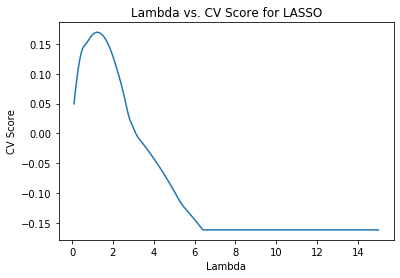


Max R^2 from LASSO: 0.16952883889166653


In [15]:
# Build a Lasso model
from sklearn.linear_model import Lasso

def RSS(y, y_pred):
    return np.sum(np.square(y - y_pred))

lasso_models = []
lasso_accuracy = []
alphas = np.linspace(0.1,15,500)
for i, alpha in enumerate(alphas):
    lasso_models.append(Lasso(alpha, max_iter=100000))
    lasso_accuracy.append(cross_val_score(lasso_models[i], X_train, y_train, cv=5).mean())

plt.plot(alphas, lasso_accuracy, '-')
plt.title('Lambda vs. CV Score for LASSO')
plt.xlabel('Lambda')
plt.ylabel('CV Score')
plt.show()

print(f'\nMax R^2 from LASSO: {max(lasso_accuracy)}')

# min_model = np.argmax(lasso_accuracy)
# print('Model coefficients:')
# for i, j in zip(lasso_models[min_model].fit(X, y).coef_, X_train.columns):
#     print(f'{j}: {i}')

In [113]:
best_lasso = lasso_models[np.argmax(lasso_accuracy)]
lasso_vars = X_train.columns[best_lasso.coef_ != 0]
lasso_vars = X_train[lasso_vars]
lasso_vars

Rainfall  WindGustSpeed  Humidity9am  Pressure9am  Cloud9am  TempDiff
1    -0.156401       0.081863    -1.685247    -0.868486 -0.527415  1.017260
2    -0.253874       0.781030    -1.729259    -1.430290 -1.233410  0.997384
3    -0.253874       3.178176    -1.201125    -0.980846 -0.174418  0.560128
4    -0.237628       0.581268     0.075197     0.011675  1.237571 -0.791392
5    -0.042683      -0.517424     1.483552     0.067856  1.590568 -1.904408
...        ...            ...          ...          ...       ...       ...
6242 -0.253874      -2.015639     1.351519    -1.074481  0.884574 -0.413761
6243 -0.253874       1.879722     0.955419    -1.149388 -0.880413  0.222248
6244 -0.253874      -1.016829     0.867397    -1.018300  1.237571  0.222248
6245 -0.253874       3.377938     0.911408    -0.512676  0.884574 -0.115632
6246 -0.172647       2.279246     0.515308    -0.344134 -1.233410  0.202373

[6244 rows x 6 columns]

In [72]:
adj_lasso_r2 = 1-(((1-max(lasso_accuracy))*(X_train.shape[0]-1))/(X_train.shape[0]-6-1))
print(f'Adjust Lasso R^2: {adj_lasso_r2}')

Adjust Lasso R^2: 0.1687299248357661


In [16]:
# Lin Model using Lasso variables
best_lasso = np.argmax(lasso_accuracy)
lasso_vars = X_train.columns[lasso_models[best_lasso].fit(X_train, y_train).coef_ != 0]

reduced_X_train = X_train[lasso_vars]

reduced_lin_model = LinearRegression()
print(f'CV score for linear model using Lasso features: {cross_val_score(reduced_lin_model, reduced_X_train, y_train).mean():.4f}')

CV score for linear model using Lasso features: 0.0539


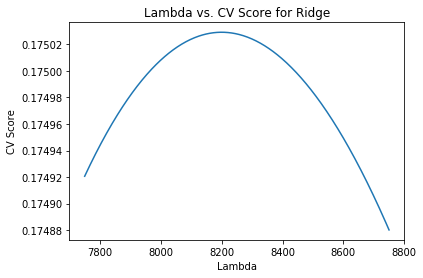


Max R^2 from Ridge: 0.17502910347657513


In [21]:
# Build ridge regression model
from sklearn.linear_model import Ridge

ridge_models = []
ridge_accuracy = []
alphas = np.linspace(7750,8750,500)
for i, alpha in enumerate(alphas):
    ridge_models.append(Ridge(alpha, max_iter=100000))
    ridge_accuracy.append(cross_val_score(ridge_models[i], X_train, y_train, cv=5).mean())

plt.plot(alphas, ridge_accuracy, '-')
plt.title('Lambda vs. CV Score for Ridge')
plt.xlabel('Lambda')
plt.ylabel('CV Score')
plt.show()

print(f'\nMax R^2 from Ridge: {max(ridge_accuracy)}')

In [81]:
adj_ridge_r2 = 1-(((1-max(ridge_accuracy))*(X_train.shape[0]-1))/(X_train.shape[0]-X_train.shape[1]))
print(f'Adjust Ridge R^2: {adj_ridge_r2}')

Adjust Ridge R^2: 0.16580931211601224


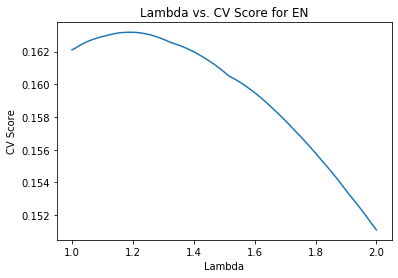


Max R^2 from Elastic Net: 0.16318073786706333


In [23]:
# Build elastic net model
from sklearn.linear_model import ElasticNet

EN_models = []
EN_accuracy = []
alphas = np.linspace(1,,100)
for i, alpha in enumerate(alphas):
    EN_models.append(ElasticNet(alpha, max_iter=100000))
    EN_accuracy.append(cross_val_score(EN_models[i], X_train, y_train, cv=5).mean())

plt.plot(alphas, EN_accuracy, '-')
plt.title('Lambda vs. CV Score for EN')
plt.xlabel('Lambda')
plt.ylabel('CV Score')
plt.show()

print(f'\nMax R^2 from Elastic Net: {max(EN_accuracy)}')

In [78]:
best_EN = EN_models[np.argmax(EN_accuracy)]
np.sum(best_EN.fit(X_train, y_train).coef_ != 0)

13

In [80]:
adj_en_r2 = 1-(((1-max(EN_accuracy))*(X_train.shape[0]-1))/(X_train.shape[0]-13-1))
print(f'Adjust EN R^2: {adj_en_r2}')

Adjust Lasso R^2: 0.1687299248357661


In [24]:
# Build SVM Regression model
from sklearn.svm import SVR

init_svr_models = []
init_svr_accuracy = []
for i, kern in enumerate(['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']):
    if kern == 'poly':
        for deg in [2,3,4]:
            init_svr_models.append(SVR(kernel=kern, degree=deg, cache_size=1000))
    else:
        init_svr_models.append(SVR(kernel=kern, cache_size=1000))
    init_svr_accuracy.append(cross_val_score(init_svr_models[i], X_train, y_train, cv=5).mean())


In [25]:
min_model = np.argmax(init_svr_accuracy)
print(f'Best model before pX_train.shapearameter tuning: {init_svr_models[min_model].get_params()}')

Best model before pX_train.shapearameter tuning: {'C': 1.0, 'cache_size': 1000, 'coef0': 0.0, 'degree': 2, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'poly', 'max_iter': -1, 'shrinking': True, 'tol': 0.001, 'verbose': False}


In [82]:
#gammas = np.linspace(0.03, 0.1, 10)
# for gam in gammas:
#     svr_model = SVR(kernel='rbf', gamma=gam)
#     print(f'CV for gamma={gam} and RBF: {cross_val_score(svr_model, X_train, y_train).mean()}')

# for gam in gammas:
#     svr_model = SVR(kernel='poly', degree=2, gamma=gam)
#     print(f'CV for gamma={gam} and poly: {cross_val_score(svr_model, X_train, y_train).mean()}')

svr_model = SVR(kernel='poly', degree=2, gamma=0.09)
svr_r2 = cross_val_score(svr_model, X_train, y_train).mean()
print(f'Max R^2 from SVR: {svr_r2}')

Max R^2 from SVR: 0.23744425096549815


In [83]:
adj_svr_r2 = 1-(((1-svr_r2)*(X_train.shape[0]-1))/(X_train.shape[0]-X_train.shape[1]-1))
print(f'Adjust SVR R^2: {adj_svr_r2}')

Adjust SVR R^2: 0.22879709359753853


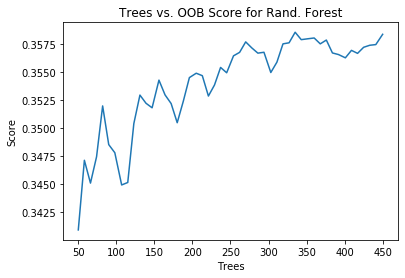

In [124]:
# Build a random forest model
from sklearn.ensemble import RandomForestRegressor

trees = np.linspace(50, 450, 50).astype(int)
RF_models = []
RF_accuracy = []

for i, tree in enumerate(trees):
    RF_models.append(RandomForestRegressor(n_estimators=tree, oob_score=True, n_jobs=-1, random_state=456789))
    RF_accuracy.append(RF_models[i].fit(X_train, y_train).oob_score_)
    
plt.plot(trees, RF_accuracy, '-')
plt.title('Trees vs. OOB Score for Rand. Forest')
plt.xlabel('Trees')
plt.ylabel('Score')
plt.show()

In [125]:
print(f'Max R^2 from Random Forest, using OOB: {np.max(RF_accuracy)}')
print(f'Best performing # of trees: {RF_models[np.argmax(RF_accuracy)].n_estimators}')

Max R^2 from Random Forest, using OOB: 0.35853756416912685
Best performing # of trees: 335


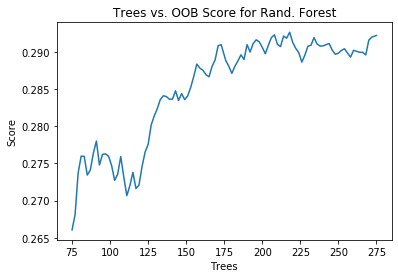

In [117]:
# Build a random forest model
from sklearn.ensemble import RandomForestRegressor

trees = np.linspace(75, 275, 100).astype(int)
lRF_models = []
lRF_accuracy = []

for i, tree in enumerate(trees):
    lRF_models.append(RandomForestRegressor(n_estimators=tree, oob_score=True, n_jobs=-1, random_state=456789))
    lRF_accuracy.append(lRF_models[i].fit(lasso_vars, y_train).oob_score_)
    
plt.plot(trees, lRF_accuracy, '-')
plt.title('Trees vs. OOB Score for Rand. Forest')
plt.xlabel('Trees')
plt.ylabel('Score')
plt.show()

In [126]:
for q in [1,0.5,'log2','sqrt','auto']:
    temp_rf_model = RandomForestRegressor(n_estimators=335, oob_score=True, n_jobs=-1, max_features=q, random_state=456789).fit(X_train, y_train)
    print(f'For max_features={q}, OOB score={temp_rf_model.oob_score_}')
    

For max_features=1, OOB score=0.31958089305744897
For max_features=0.5, OOB score=0.3712012367408205
For max_features=log2, OOB score=0.3793587342043523
For max_features=sqrt, OOB score=0.3799571326777599
For max_features=auto, OOB score=0.35853756416912685


In [127]:
best_rf = RandomForestRegressor(n_estimators=335, oob_score=True, n_jobs=-1, max_features='sqrt', random_state=456789).fit(X_train, y_train)
adj_rf_r2 = 1-(((1-best_rf.oob_score_)*(X_train.shape[0]-1))/(X_train.shape[0]-X_train.shape[1]-1))
print(f'Adjust Rand Forest R^2: {adj_rf_r2}')

Adjust Rand Forest R^2: 0.3729260293710116


In [46]:
from IPython.display import Image

full_data = pd.merge(left=X, right=y, left_index=True, right_index=True)

sns_plot = sns.pairplot(full_data, height=2.0)
sns_plot.savefig("pairplot.png")

plt.clf() # Clean parirplot figure from sns 
Image(filename='pairplot.png') # Show pairplot as image

<Figure size 10224x10224 with 0 Axes>

In [40]:
from sklearn.neural_network import MLPRegressor

# https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw
# Link above says that the large majority of NN's perform just as well with 1 layer as with multiple, and that
# the optimal number of nodes is almost always somewhere between the number of inputs (72) and the number of outputs (1)
# layers = np.linspace(26, 45, 20).astype(int)
# nn_models = []
# nn_accuracy = []
# for i, layer in enumerate(layers):
#     nn_models.append(MLPRegressor(hidden_layer_sizes=layer, max_iter=20000))
#     nn_accuracy.append(cross_val_score(nn_models[i], X_train, y_train))

nn_model = MLPRegressor(hidden_layer_sizes = 36, max_iter=20000)
print(f'Neural Net score: {cross_val_score(nn_model, X_train, y_train, cv=5).mean()}')

Neural Net score: -0.8194483178737848


In [43]:
from sklearn.ensemble import AdaBoostRegressor

AB_model = AdaBoostRegressor()
print(f'AdaBoost Score: {cross_val_score(AB_model, X_train, y_train).mean()}')



AdaBoost Score: -9.69402989855735


## Best model score from above: Random Forest w/ adjusted r^2 of 0.373

In [129]:
from sklearn.metrics import mean_absolute_error, roc_auc_score, accuracy_score,\
precision_score, recall_score, f1_score, mean_squared_error, make_scorer, explained_variance_score, r2_score

# def mean_absolute_percentage_error(y_true, y_pred):
#     denom = np.where(abs(y_true)<0.0000001,0.0000001, abs(y_true))
#     error_sum = (abs(y_true - y_pred)/denom).sum()
#     return error_sum/len(y_true)

# def root_mean_squared_error(y_true, y_pred):
#     return mean_squared_error(y_true, y_pred, squared=False)
    
MAE = make_scorer(mean_absolute_error)#, greater_is_better=False)
MAPE = make_scorer(mean_absolute_percentage_error)#, greater_is_better=False)
RMSE = make_scorer(root_mean_squared_error)#, greater_is_better=False)
MSE = make_scorer(mean_squared_error)#, greater_is_better=False)
exp_var = make_scorer(explained_variance_score)#, greater_is_better=False)
r_squared = make_scorer(r2_score)#, greater_is_better=False)
RF_r2 = cross_val_score(best_rf, X_test, y_test, scoring=r_squared).mean()

print(f'MAE using 5-fold CV: {cross_val_score(best_rf, X_test, y_test, scoring=MAE).mean()}')
# print(f'MAPE using 5-fold CV: {cross_val_score(best_rf, X_test, y_test, scoring=MAPE).mean()}')
# print(f'RMSE using 5-fold CV: {cross_val_score(best_rf, X_test, y_test, scoring=RMSE).mean()}')
print(f'MSE using 5-fold CV: {cross_val_score(best_rf, X_test, y_test, scoring=MSE).mean()}')
print(f'R^2 using 5-fold CV: {RF_r2}')
print(f'Explained Variance using 5-fold CV: {cross_val_score(best_rf, X_test, y_test, scoring=exp_var).mean()}')
# print(f'PM using 5-fold CV: {1-RF_r2}')

MAE using 5-fold CV: 3.9442515125393527
MAPE using 5-fold CV: 10864007.908008464
RMSE using 5-fold CV: 9.961234827003068
MSE using 5-fold CV: 107.15178946072808
R^2 using 5-fold CV: 0.26519952567272176
MSE using 5-fold CV: 0.2706559154607997
PM using 5-fold CV: 0.7348004743272782
